# Install the libraries

In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import AdaptiveEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    adapt = AdaptiveEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

# Inpainting

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Config

In [3]:
config["exp_params"]["batch_size"] = 1
dm = mnist_dataloader_test(config, path=path)

In [4]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

# Adaptive Experiments

In [5]:
config["operator_params"]["size"] = 28

In [7]:
def adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    avg_error = []
    for i in range(20):
        imgs = torch.zeros(100, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in trange(0, 100):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.adaptive_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        plt.show()
    return avg_error

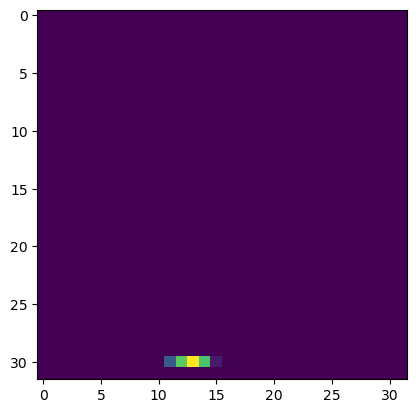

100%|██████████| 100/100 [00:04<00:00, 24.97it/s]
/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


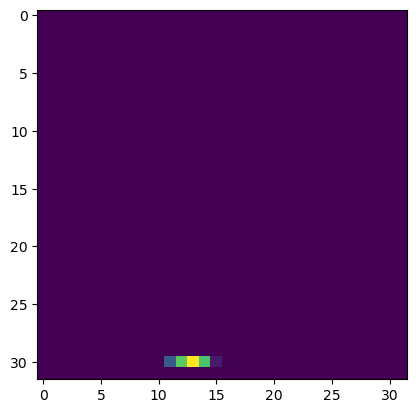

100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


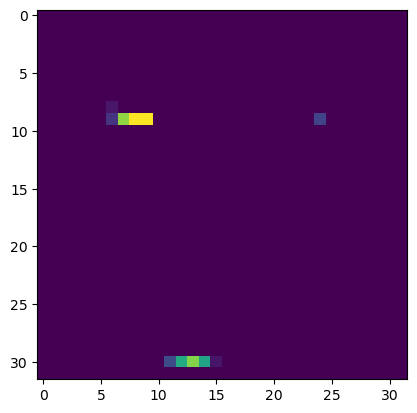

100%|██████████| 100/100 [00:03<00:00, 29.51it/s]


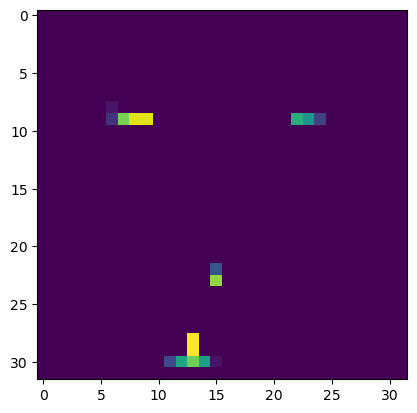

100%|██████████| 100/100 [00:03<00:00, 29.14it/s]


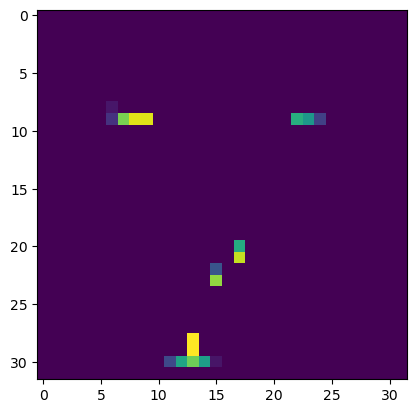

100%|██████████| 100/100 [00:03<00:00, 28.82it/s]


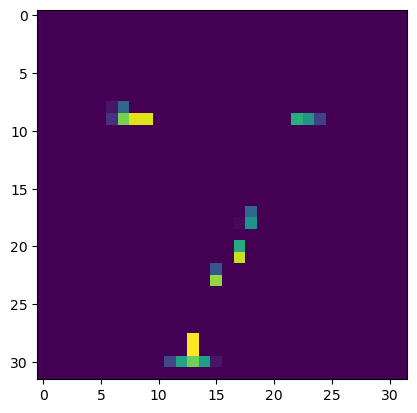

100%|██████████| 100/100 [00:03<00:00, 30.19it/s]


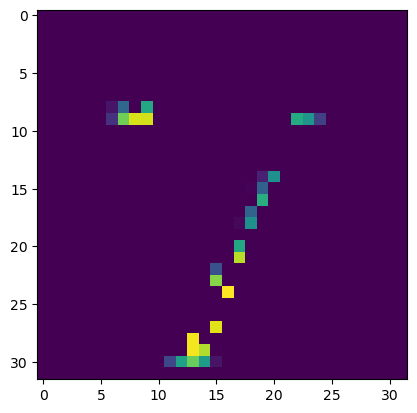

100%|██████████| 100/100 [00:03<00:00, 29.00it/s]


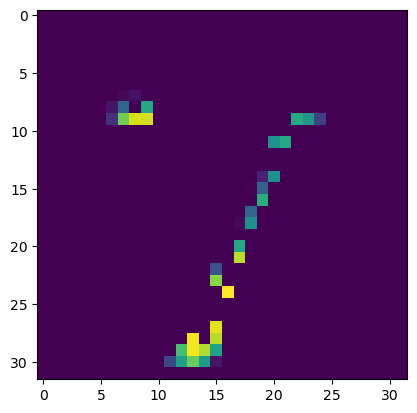

100%|██████████| 100/100 [00:03<00:00, 28.59it/s]


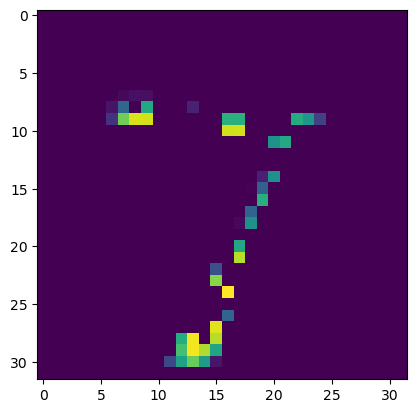

100%|██████████| 100/100 [00:03<00:00, 28.97it/s]


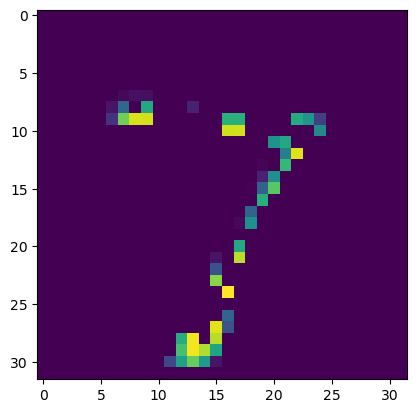

100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


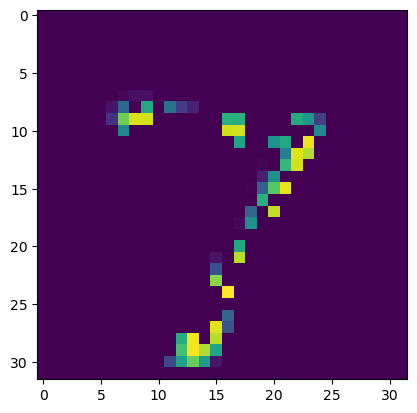

100%|██████████| 100/100 [00:03<00:00, 32.63it/s]


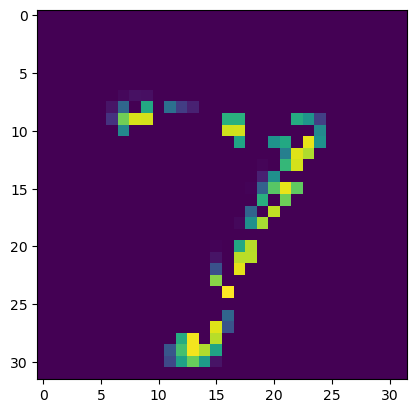

100%|██████████| 100/100 [00:03<00:00, 30.29it/s]


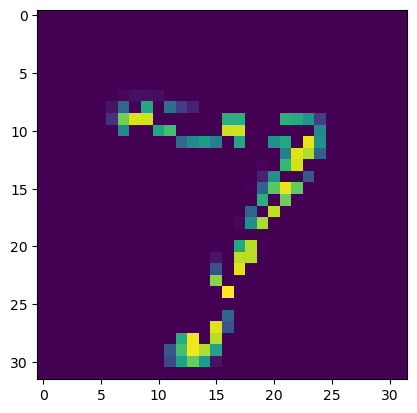

100%|██████████| 100/100 [00:03<00:00, 29.10it/s]


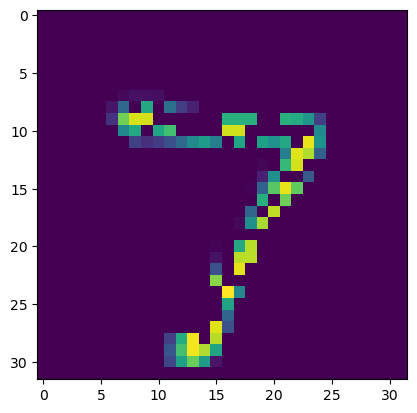

100%|██████████| 100/100 [00:03<00:00, 29.14it/s]


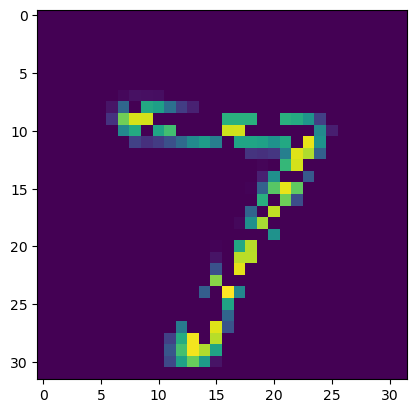

100%|██████████| 100/100 [00:03<00:00, 28.97it/s]


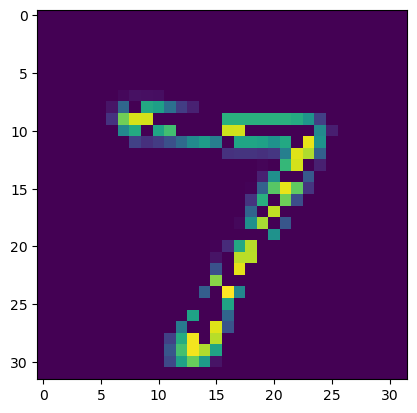

100%|██████████| 100/100 [00:03<00:00, 28.91it/s]


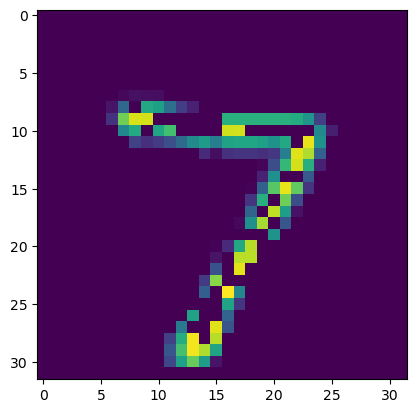

100%|██████████| 100/100 [00:03<00:00, 31.34it/s]


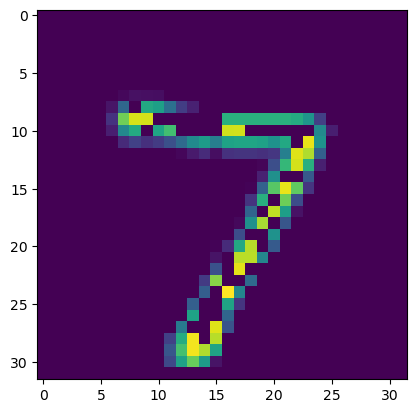

100%|██████████| 100/100 [00:03<00:00, 29.29it/s]


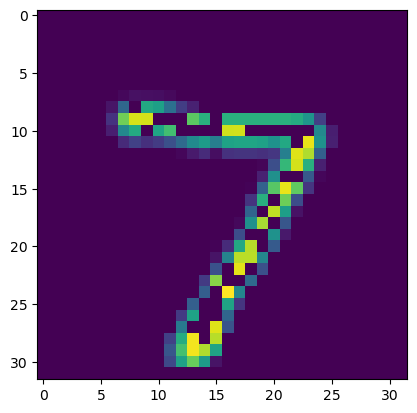

100%|██████████| 100/100 [00:03<00:00, 29.10it/s]


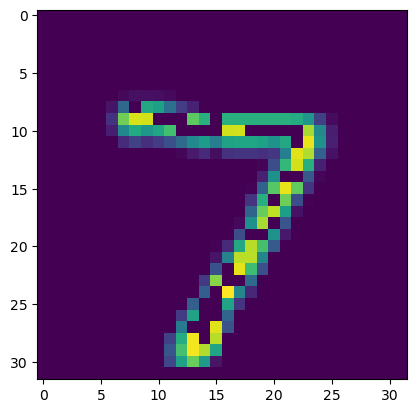

100%|██████████| 100/100 [00:03<00:00, 29.12it/s]


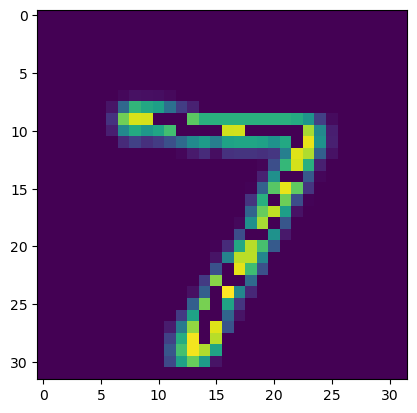

In [8]:
avg_error = adaptive_iteration(x)

In [11]:
def non_adaptive_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    avg_error = []
    for i in range(20):
        imgs = torch.zeros(100, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        error = []
        for num in trange(0, 100):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
            error.append(reconstruction_error(x, x_hat).detach().cpu())
        avg_error.append(sum(error)/len(error))
        A = adapt.non_adaptive_sample(imgs)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        plt.show()
    return avg_error

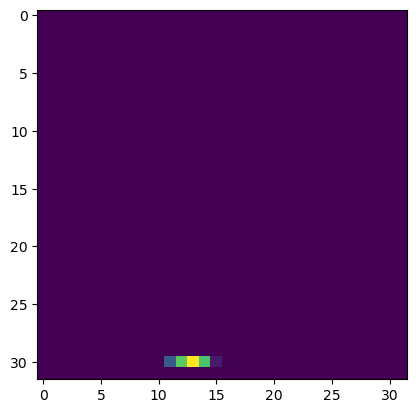

100%|██████████| 100/100 [00:03<00:00, 29.05it/s]


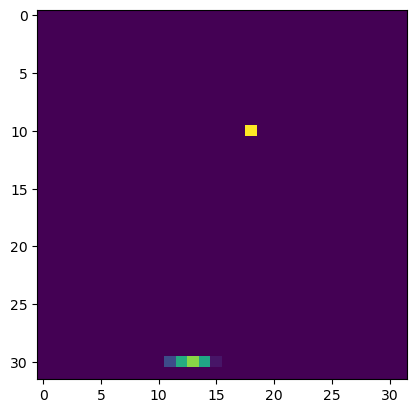

100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


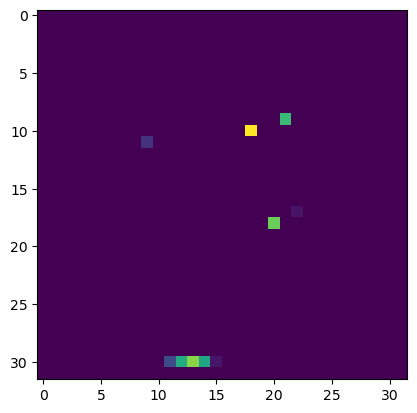

100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


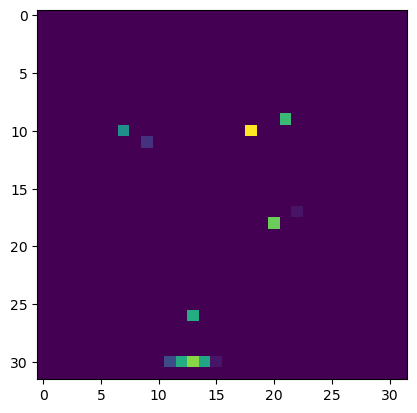

100%|██████████| 100/100 [00:03<00:00, 29.92it/s]


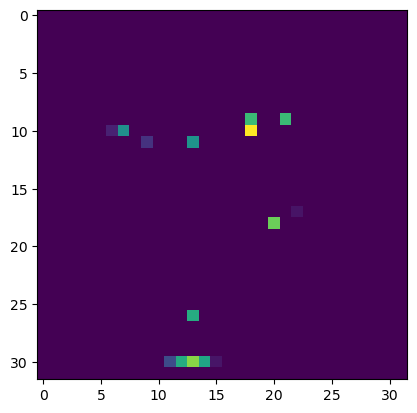

100%|██████████| 100/100 [00:03<00:00, 29.19it/s]


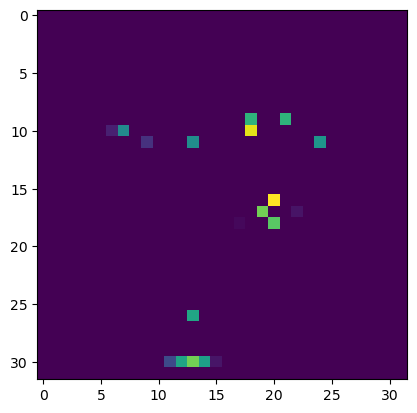

100%|██████████| 100/100 [00:03<00:00, 29.06it/s]


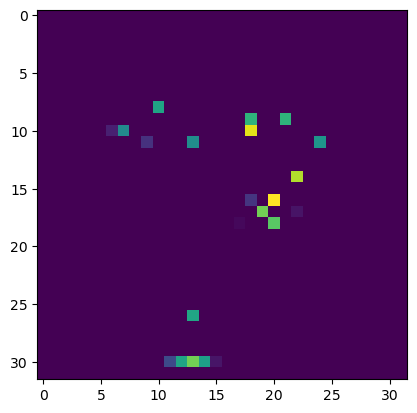

100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


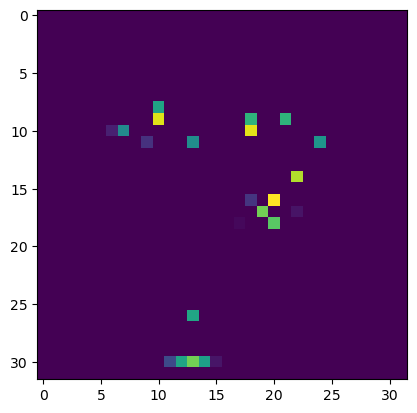

100%|██████████| 100/100 [00:03<00:00, 29.42it/s]


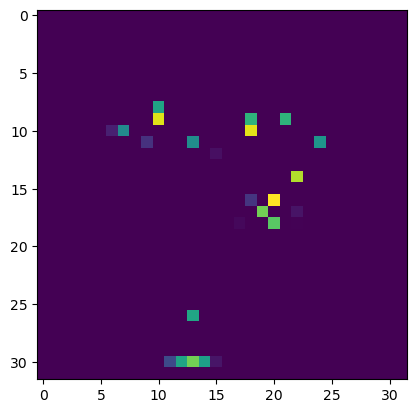

100%|██████████| 100/100 [00:03<00:00, 28.99it/s]


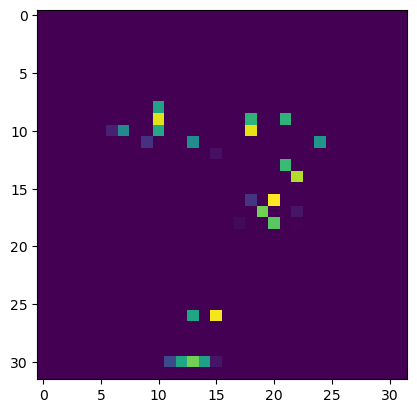

100%|██████████| 100/100 [00:03<00:00, 28.81it/s]


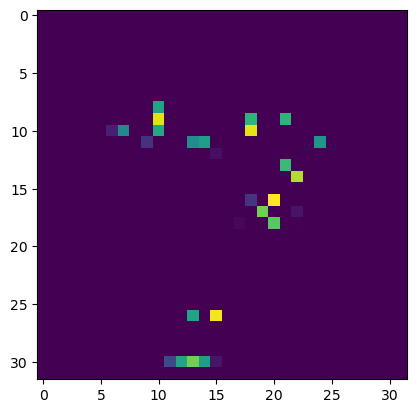

100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


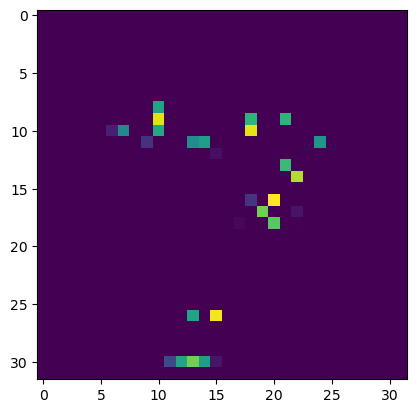

100%|██████████| 100/100 [00:03<00:00, 29.15it/s]


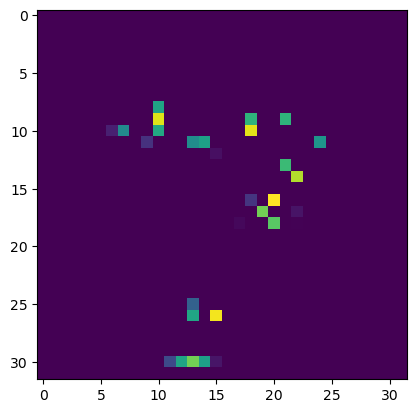

100%|██████████| 100/100 [00:03<00:00, 29.05it/s]


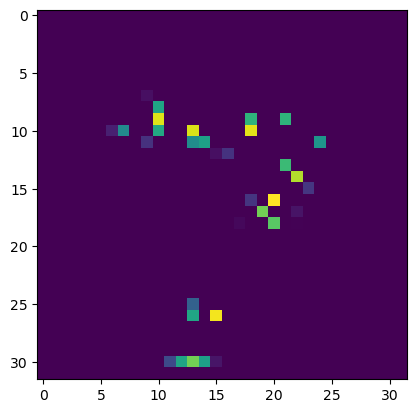

100%|██████████| 100/100 [00:03<00:00, 29.15it/s]


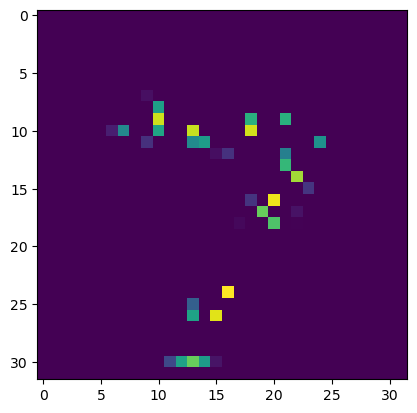

100%|██████████| 100/100 [00:03<00:00, 28.92it/s]


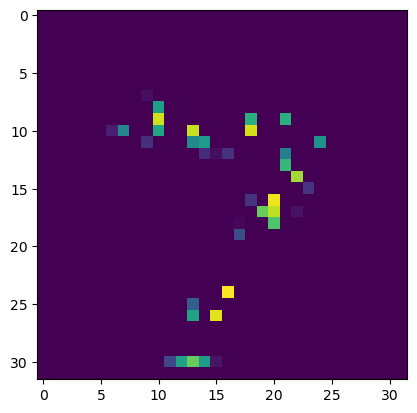

100%|██████████| 100/100 [00:03<00:00, 28.88it/s]


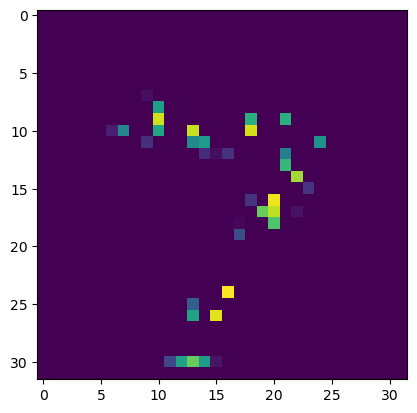

100%|██████████| 100/100 [00:03<00:00, 29.13it/s]


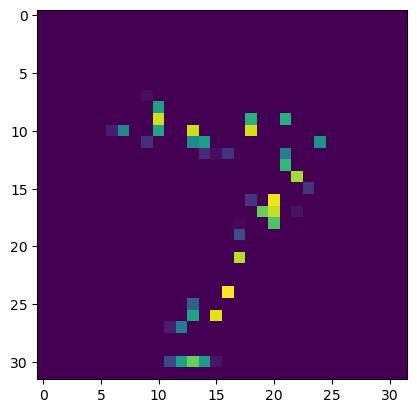

100%|██████████| 100/100 [00:03<00:00, 29.52it/s]


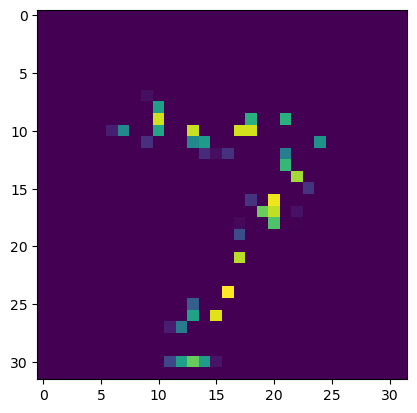

100%|██████████| 100/100 [00:03<00:00, 29.06it/s]


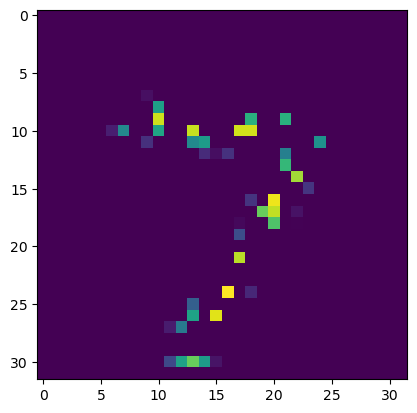

100%|██████████| 100/100 [00:03<00:00, 29.24it/s]


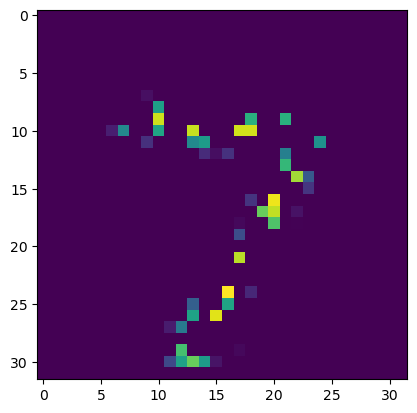

In [12]:
avg_error_non_adptive = non_adaptive_iteration(x)

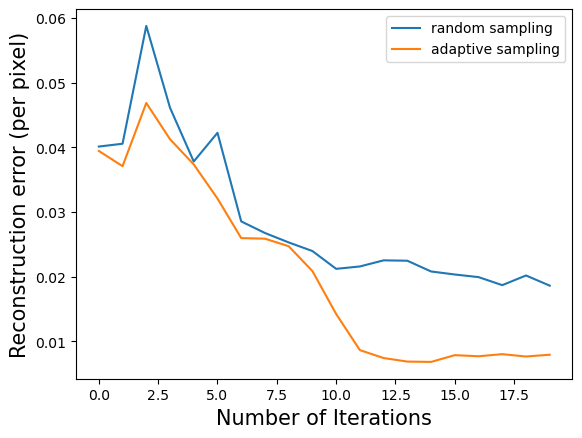

In [18]:
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.plot(avg_error_non_adptive)
plt.plot(avg_error)
plt.legend(['random sampling','adaptive sampling'])
plt.show()